In [76]:
## IMPORTS

# External modules
import pandas as pd
import matplotlib.pyplot as plt
# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, precision_score, recall_score, f1_score
import re
import string_handle

In [47]:
## FUNCTIONS


def analyse_by_column(dataframe, column_name, threshold):
    artworks_count_by_segment = dataframe[column_name].value_counts()
    selection = artworks_count_by_segment[artworks_count_by_segment > threshold].index
    dataframe = dataframe[dataframe[column_name].isin(selection)]
    return dataframe

def calculate_area_and_price_per_area(dataframe, column_name):
    # Iterate over the "Size" column
    df = dataframe.copy()
    for i, size in enumerate(dataframe[column_name]):
        # Extract the dimensions using regular expression
        dimensions = re.findall(r'\d+(?:\.\d+)?', size)
        if len(dimensions) >= 2:
            # Extract the width and height dimensions
            try:
                width = float(dimensions[0])
                height = float(dimensions[1])
                total_area = width * height
                df.at[i, 'Size'] = total_area
            except:
                df.at[i, 'Size'] = 'NaN'
    df['Price / in²'] = df['Price'] / df['Size']

    return df




def get_unique_values(df, column_name):
    # Extract all unique styles from the column
    unique_values = set()
    for styles in df[column_name]:
        if isinstance(styles, str):
            styles_list = [style.strip() for style in styles.split(',')]
            unique_values.update(styles_list)
    
    return unique_values



In [16]:
## MODELS


def get_stats(x, y):
    stats = {}
    for variable in [x, y]:
        max_variable = round(max(variable), 2)
        min_variable = round(min(variable), 2)
        mean_variable = round(variable.mean(), 2)
        median_variable = round(variable.median(), 2)
        stats_variable = {'Max': max_variable, 'Min': min_variable, 'Mean': mean_variable, 'Median': median_variable}
        # add stats_variable to stats
        stats[variable] = stats_variable
    return stats


## GET MODELS

def get_decision_tree(X_train, y_train):
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X_train, y_train)
    return decision_tree

def get_linear_regression(X_train, y_train):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    return linear_regression

def get_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(random_state=1)
    rf_model.fit(X_train, y_train)
    return rf_model

def get_gradient_boosting(X_train, y_train):
    # get gradient boosting model
    gb_model = GradientBoostingRegressor(random_state=1)
    gb_model.fit(X_train, y_train)
    return gb_model

# gives a dataframe taking models as columns and score as rows
def get_all_models(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

    models = {'Linear regression': get_linear_regression(x_train, y_train),
              'Decision tree': get_decision_tree(x_train, y_train),
              'Random forest': get_random_forest(x_train, y_train),
              'Gradient boosting': get_gradient_boosting(x_train, y_train)}
    models_df = pd.DataFrame(columns=models.keys())
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        p = x_test.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mean_error = mean_absolute_error(y_test, y_pred)

        models_df.loc['score', model_name] = r2
        models_df.loc['adjusted score', model_name] = adj_r2
        models_df.loc['mean error', model_name] = mean_error

    return models_df, models

In [4]:
## CHARTS

dark_green_color_code = '#195921'
gold_color_code = '#FFD700'
black_color_code = '#000000'
salmon_color_code = '#FA8072'

def plot_segment_chart(dataframe, segments_column_name, bar_column_name, line_columns_names, title):
    bar_color_code = dark_green_color_code
    line_colors_codes = [gold_color_code, black_color_code]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax1.bar(dataframe.index, dataframe[bar_column_name], color=bar_color_code)
    for line_column_name in line_columns_names:
        ax2.plot(dataframe.index, dataframe[line_column_name], label=line_column_name, color=line_colors_codes.pop(0))
    ax2.legend()
    ax1.set_xticklabels(dataframe.index, rotation=90)
    ax1.set_ylabel(bar_column_name)
    ax2.set_ylabel(str(line_columns_names))
    ax1.set_xlabel(segments_column_name)
    ax1.set_title(title)
    # beautify and enhance readability of the chart
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1.tick_params(axis='x', which='major', labelsize=8)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax2.tick_params(axis='y', which='major', labelsize=8)

    plt.show()


# SCATTER PLOT: SIZE VS PRICE
def plot_scatter(dataframe, x_column_name, y_columnname, title):
    plt.scatter(x=dataframe[x_column_name], y=dataframe[y_columnname], c=dark_green_color_code)
    plt.title(title)
    plt.xlabel(x_column_name)
    plt.ylabel(y_columnname)
    # improve readability of the chart
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    # set color of scatter points as dark green
    
    plt.show()

In [98]:
blombo = pd.read_csv('../temporary-files/blombo_artworks_info.csv')
blombo.dropna(subset=['Dimensões'], inplace=True)
blombo['Dimensões'] = blombo['Dimensões'].apply(lambda x: x.replace('X', 'x'))
blombo = blombo[blombo['Dimensões'].str.contains('x')]
blombo['Height'] = blombo['Dimensões'].apply(lambda x: float(string_handle.get_number(x.split('x')[0].strip() if isinstance(x,str) else None)))
blombo['Width'] = blombo['Dimensões'].apply(lambda x: float(string_handle.get_number(x.split('x')[1].strip() if isinstance(x,str) else None)))
blombo['Area'] = blombo['Height'] * blombo['Width']

blombo.Title = blombo.Title.apply(lambda x: x.replace('Título:', '').strip())

In [164]:
## CONCATENATE DATAFRAMES

paintings_keywords = ['pintura', 'painting', 'tela', 'acrílica',
                      'Pintura', 'Painting', 'Canvas', 'Acrílica',
                      'Óleo', 'Oil', 'tinta', 'aquarela', 'Tinta',
                      'Aquarela', 'watercolor', 'Watercolor', 'ink',
                      'Ink', 'Pastel', 'pastel']

# ART RIO
artrio = pd.read_csv('../temporary-files/artrio_artworks_info.csv')
artrio['Platform'] = 'Art Rio'
artrio.drop(columns=['ARTE HALL', 'MOVIMENTO ', 'Galeria Athena',
       'Arte FASAM Galeria', 'MARTHA PAGY ESCRITÓRIO DE ARTE',
       'EDITORA COBOGÓ', 'MUL.TI.PLO ESPAÇO ARTE', 'Artistas Latinas',
       'Lona Galeria', 'MERCEDES VIEGAS ARTE CONTEMPORÂNEA',
       'CASSIA BOMENY GALERIA', 'CARCARA PHOTO ART', 'PORTAS VILASECA GALERIA',
       'C.GALERIA', 'RV CULTURA E ARTE', 'Central Galeria', 'NARA ROESLER',
       'LUCIANA BRITO GALERIA', 'JANAINA TORRES GALERIA',
       'MATIAS BROTAS ARTE CONTEMPORÂNEA',
       'GABY INDIO DA COSTA ARTE CONTEMPORÂNEA', 'Aura Galeria',
       'CARBONO GALERIA', 'OMA Galeria',
       'MARCIA BARROZO DO AMARAL - Galeria de Arte',
       "FORTES D'ALOIA & GABRIEL", 'SILVIA CINTRA + BOX 4',
       'SIMÕES DE ASSIS GALERIA', 'FÓLIO', 'GALERIA ESTAÇÃO', 'GALERIA LUME',
       'BORDALLO', 'ANITA SCHWARTZ GALERIA ', 'GALERIA MAPA',
       'Metaverse Agency  ', 'Yaak Gallery', 'Superfície',
       'GALERIA MARIO COHEN', 'GUSTAVO REBELLO ARTE', 'MILLAN', 'SÉ',
       'ACERVO GALERIA DE ARTE'], inplace=True)
artrio.rename(columns={'Price / cm2': 'Price / cm²'}, inplace=True)
artrio.fillna('', inplace=True)
artrio = artrio[artrio['Ficha técnica'].str.contains('|'.join(paintings_keywords))].reset_index(drop=True)
print(artrio.shape)

# ART SOUL
artsoul = pd.read_csv('../temporary-files/artsoul_artworks_info.csv')
artsoul['Platform'] = 'Art Soul'
artsoul.rename(columns={'Size': 'Area', 'Price / in²': 'Price / cm²'}, inplace=True)
artsoul.fillna('', inplace=True)
artsoul = artsoul[(artsoul['Description'].str.contains('|'.join(paintings_keywords))) | (artsoul['Techniques'].str.contains('|'.join(paintings_keywords)))].reset_index(drop=True)
print(artsoul.shape)

# SP ARTE
sparte = pd.read_csv('../temporary-files/sparte_artworks_info.csv')
sparte['Platform'] = 'SP Arte'
sparte.rename(columns={'Size': 'Area'}, inplace=True)
sparte = sparte[sparte['Description'].str.contains('|'.join(paintings_keywords))].reset_index(drop=True)
print(sparte.shape)

# BLOMBO
blombo = pd.read_csv('../temporary-files/blombo_artworks_info.csv')
blombo.dropna(subset=['Dimensões'], inplace=True)
blombo['Dimensões'] = blombo['Dimensões'].apply(lambda x: x.replace('X', 'x'))
blombo = blombo[blombo['Dimensões'].str.contains('x')]
blombo['Height'] = blombo['Dimensões'].apply(lambda x: float(string_handle.get_number(x.split('x')[0].strip())) if isinstance(x,str) else None)
blombo['Width'] = blombo['Dimensões'].apply(lambda x: float(string_handle.get_number(x.split('x')[1].strip())) if isinstance(x,str) else None)
blombo['Area'] = blombo['Height'] * blombo['Width']
blombo['Platform'] = 'Blombo'
blombo['Price'] = blombo['Price'].apply(lambda x: float(string_handle.get_number(x)[:-2]) if isinstance(x,str) else None)
blombo.rename(columns={'Anos': 'Year', 'Suporte da Obra': 'Mediums', 'Técnica': 'Techniques'}, inplace=True)
blombo['Year'] = blombo['Year'].fillna(blombo['Data'].str.extract(r'(\d{4})', expand=False))
blombo.drop(columns=['Dimensões', 'Data'], inplace=True)
blombo = blombo[(blombo['Mediums'].str.contains('|'.join(paintings_keywords))) | (blombo['Techniques'].str.contains('|'.join(paintings_keywords)))].reset_index(drop=True)
print(blombo.shape)

# Concatenate the dataframes
artworks_info = pd.concat([artrio, artsoul, sparte, blombo], ignore_index=True)
# columns = ['Title', 'Artist', 'Price', 'Area', 'Price / cm²', 'Gallery', 'Platform']
# artworks_info = artworks_info[columns]

# Remove artworks with no Price or no Area
artworks_info = artworks_info[(artworks_info['Price'] != '') & (artworks_info['Area'] != '')].reset_index(drop=True)

(380, 13)
(158, 16)
(364, 13)
(663, 25)


In [165]:
# artworks_info.drop(columns=['Estado de conservação', 'Meses de Anúncio', 'Assinatura', 'Tiragem', ], inplace=True)
# show non-null values of data column
# artworks_info['Data'][artworks_info['Data'].notnull()].to_list()

87
72


In [23]:
## REMOVE OUTLIERS

# remove 0.05 and 0.95 quantiles of price / cm²

# artworks_info = artworks_info[(artworks_info['Price / cm²'] > artworks_info['Price / cm²'].quantile(0.05)) &
#                                 (artworks_info['Price / cm²'] < artworks_info['Price / cm²'].quantile(0.95))]

In [101]:
## ARTWORKS BY SEGMENT
column_name1 = 'Platform'
sort_by1 = 'Mean Price'
min_frequency1 = 2

In [115]:
## ARTWORKS BY SEGMENT

artworks = artworks_info.copy()

artworks_by_segment = analyse_by_column(artworks, column_name1, min_frequency1)
# Get mean price per segment as 'Mean Price' column
mean_price_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price': 'mean'})
median_price_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price': 'median'})
mean_price_per_in_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price / cm²': 'mean'})
median_price_per_in_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price / cm²': 'median'})
col_analysis_by_segment = pd.concat([mean_price_by_segment, median_price_by_segment, mean_price_per_in_by_segment, median_price_per_in_by_segment, artworks[column_name1].value_counts()], axis=1)
col_analysis_by_segment.columns = ['Mean Price', 'Median Price','Mean Price / cm²', 'Median Price / cm²', 'Count']
col_analysis_by_segment = col_analysis_by_segment[col_analysis_by_segment['Count'] > min_frequency1]

col_analysis_by_segment.sort_values(by=sort_by1, ascending=False, inplace=True)
#col_analysis_by_segment = col_analysis_by_segment.dropna()

plot_segment_chart(col_analysis_by_segment, column_name1, 'Count', ['Mean Price', 'Median Price'], 'Artworks by ' + column_name1)
col_analysis_by_segment

TypeError: Could not convert R$80.000,00R$80.000,00R$4.000,00R$9.500,00 R$2.500,00R$72.000,00 R$7.500,00 R$7.800,00 R$17.000,00 R$16.000,00 R$13.000,00 R$19.500,00 R$34.000,00 R$6.200,00 R$34.000,00 R$12.000,00R$7.000,00R$7.000,00R$6.500,00 R$13.700,00 R$70.000,00R$70.000,00R$39.000,00R$13.000,00R$290.000,00R$290.000,00R$16.000,00 to numeric

In [126]:
# for each platform, get mean price
platforms = artworks_info['Platform'].unique()

platforms_analysis = {}

for platform in platforms:
    platform_analysis = {}
    platform_analysis['Mean Price'] = artworks_info[artworks_info['Platform'] == platform]['Price'].mean()
    platform_analysis['Median Price'] = artworks_info[artworks_info['Platform'] == platform]['Price'].median()
    platform_analysis['Max Price'] = artworks_info[artworks_info['Platform'] == platform]['Price'].max()
    platform_analysis['Mean Price / cm²'] = artworks_info[artworks_info['Platform'] == platform]['Price / cm²'].mean()
    platform_analysis['Median Price / cm²'] = artworks_info[artworks_info['Platform'] == platform]['Price / cm²'].median()
    platform_analysis['Max Price / cm²'] = artworks_info[artworks_info['Platform'] == platform]['Price / cm²'].max()
    platform_analysis['Artworks Count'] = artworks_info[artworks_info['Platform'] == platform]['Title'].count()
    platform_analysis['Artists Count'] = artworks_info[artworks_info['Platform'] == platform]['Artist'].nunique()
    platforms_analysis[platform] = platform_analysis


# platforms_analysis to dataframe
platforms_analysis_df = pd.DataFrame.from_dict(platforms_analysis, orient='index')
# round all values
platforms_analysis_df = platforms_analysis_df.round(2)
# sort by mean price
platforms_analysis_df.sort_values(by='Mean Price', inplace=True, ascending=False)
platforms_analysis_df

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Mean Price,Median Price,Max Price,Mean Price / cm²,Median Price / cm²,Max Price / cm²,Artworks Count,Artists Count
SP Arte,59456.67,25000.0,1000000.0,17.42,2.55,512.82,364,224
Blombo,31649.96,15500.0,450000.0,NaN,NaN,NaN,226,109
Art Rio,22168.67,9750.0,300000.0,13.76,4.17,484.26,380,162
Art Soul,6210.74,4500.0,40000.0,NaN,NaN,NaN,147,92


Text(0.5, 1.0, 'Preço x Área')

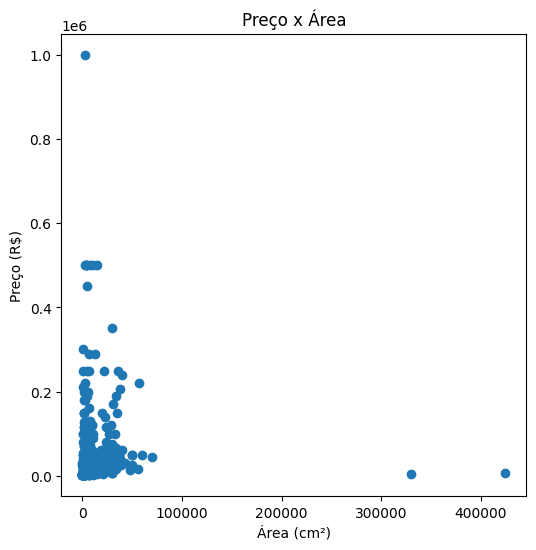

In [127]:
## PLOT PRICE x AREA
platform_for_scatter = 'SP Arte'

dataframe = artworks_info#[artworks_info['Platform'] == platform_for_scatter]

plt.figure(figsize=(6,6))
plt.scatter(dataframe['Area'], dataframe['Price'])
plt.xlabel('Área (cm²)')
plt.ylabel('Preço (R$)')
plt.title('Preço x Área')